<a href="https://colab.research.google.com/github/Gyeong-Hyeon/TOXIC_SPEECH_DETECTION/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install -q --upgrade ipython==5.5.0
!pip install -q --upgrade ipykernel==4.10

In [ ]:
#Pytorch TPU setting

!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

In [ ]:
import gc
import os
import time
import math
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup, SqueezeBertTokenizer, SqueezeBertForSequenceClassification
from sklearn.metrics import *
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import torch_xla
import torch_xla.core.xla_model as xm

from torch import Tensor
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data.sampler import RandomSampler
from torch.optim.lr_scheduler import *
from sklearn.model_selection import train_test_split

In [ ]:
#Fix seed for Pytorch
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 10
seed_everything(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech", num_labels=2)
state_dict = torch.load('/content/drive/MyDrive/finalproject/roberta_ver2/E-1_VL-0.3701/pytorch_model.bin')
model.load_state_dict(state_dict)

device = xm.xla_device()
model = model.to(device)

xm.save(model.state_dict(), '/content/drive/MyDrive/finalproject/roberta_ver2/ds_ver2_rb_vl_0.3701.pth')

#Data Version 1. Basic cleansing

In [ ]:
import pandas as pd

ver1 = pd.read_csv('/content/drive/MyDrive/finalproject/finaldata/finaldata.csv')
ver1 = ver1.dropna()
ver1 = ver1[~(ver1.duplicated())]
ver1

,target,cleaned_comment
0,0.0,if lauren is t suggesting to deport this gross...
1,0.0,f in chat for corbin he s clearly constantly a...
2,0.0,congratulations to thando and his fianca let t...
3,0.0,if you think that all b
4,0.0,before anyone says anything i am gonna get nic...
...,...,...
300996,1.0,rebellion protest etc etc etc there you have i...
300997,1.0,who is jerk in last row between c e
300998,1.0,nobody really cares that she supports science ...
300999,1.0,i take your point but i think you re shooting ...


In [ ]:
def sampling_func(data, n_sample):
    np.random.seed(10)
    N = len(data)
    sample = data.take(np.random.permutation(N)[:n_sample])
    return sample

ver1 = ver1.groupby('target', group_keys=False).apply(sampling_func, n_sample=100000)
ver1.shape

(200000, 2)

In [ ]:
ver1.isnull().sum()

target             0
cleaned_comment    0
dtype: int64

In [ ]:
max_len = max(len(comment) for comment in ver1.cleaned_comment)
max_len

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(ver1['cleaned_comment'], ver1['target'], test_size=0.4, random_state=10, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.3, random_state=10, shuffle=True)

X_train.shape, X_val.shape, X_test.shape

((176369,), (82306,), (35274,))

##RoBERTa

In [ ]:
import torch_xla
import torch_xla.core.xla_model as xm

tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech", num_labels=2)
state_dict = torch.load('/content/drive/MyDrive/finalproject/roberta/E-1/VL-0.6926/pytorch_model.bin')
model.load_state_dict(state_dict)

device = xm.xla_device()
model = model.to(device)
epochs = 5
batch_size = 32
warmup_prop = 0.1
lr = 1e-4

In [ ]:
def encode(text):
    return tokenizer(text, padding='max_length')

enc_train = X_train.map(encode)
enc_val = X_val.map(encode)
enc_test = X_test.map(encode)

In [ ]:
enc_test

132577    [input_ids, attention_mask]
51199     [input_ids, attention_mask]
92565     [input_ids, attention_mask]
130469    [input_ids, attention_mask]
219579    [input_ids, attention_mask]
                     ...             
30457     [input_ids, attention_mask]
123345    [input_ids, attention_mask]
120899    [input_ids, attention_mask]
207231    [input_ids, attention_mask]
36215     [input_ids, attention_mask]
Name: cleaned_comment, Length: 36121, dtype: object

In [ ]:
# class DiabetesDataset(Dataset):
#     """ Diabetes dataset."""

#     # Initialize your data, download, etc.
#     def __init__(self,X,y):
#         super().__init__()
#         self.len = X.shape[0]
#         self.id = torch.tensor([data['input_ids'] for data in X], dtype=torch.long)
#         self.mask = torch.tensor([data['attention_mask'] for data in X], dtype=torch.long)
#         self.label = torch.from_numpy(y.values)

#     def __getitem__(self, index):
#         return self.id[index], self.mask[index], self.label[index]

#     def __len__(self):
#         return self.len

In [ ]:
def torch_dataset(X,y):
    id = torch.tensor([data['input_ids'] for data in X], dtype=torch.long)
    mask = torch.tensor([data['attention_mask'] for data in X], dtype=torch.long)
    label = torch.tensor(y.values, dtype=torch.long)
    return TensorDataset(id, mask, label)

train = torch_dataset(enc_train, y_train)
val = torch_dataset(enc_val, y_val)
train_loader = DataLoader(train, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val, shuffle=False, batch_size=batch_size)

In [ ]:
def train(model, train_loader, val_loader, epochs=8, batch_size=16, warmup_prop=0, lr=5e-4):

    optimizer = AdamW(model.parameters(), lr=lr)
    
    num_warmup_steps = int(warmup_prop * epochs * len(train_loader))
    num_training_steps = epochs * len(train_loader)
    
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)
    
    for epoch in trange(epochs, desc="Epoch"):
        model.train()
        start_time = time.time()
        
        optimizer.zero_grad()
        total_loss = 0
        for step, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc="Iteration"):
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, labels = batch
               
            outputs = model(input_ids,  
                    attention_mask=input_mask, 
                    labels=labels)

            loss = outputs[0]
            total_loss += loss.item()
            
            loss.backward()
            xm.optimizer_step(optimizer, barrier=True)
            optimizer.step()
            scheduler.step()
            model.zero_grad()
            optimizer.zero_grad()

        avg_train_loss = total_loss / len(train_loader)

        model.eval()
        avg_val_loss = 0.

        with torch.no_grad():
            for batch in tqdm(val_loader):
                batch = tuple(t.to(device) for t in batch)
                input_ids, input_mask, labels = batch
               
                outputs = model(input_ids,  
                        attention_mask=input_mask, 
                        token_type_ids=None,
                        labels=labels)

                loss = outputs[0]
                avg_val_loss += loss.item() / len(val_loader)
                
        
        #save model on every epoch
        output_dir = os.path.join('/content/drive/MyDrive/finalproject/roberta', f'E-{epoch+1}/VL-{avg_val_loss:.4f}')
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model.save_pretrained(output_dir)
        print(f"Saving model checkpoint to {output_dir}")
            
        dt = time.time() - start_time
        lr = scheduler.get_last_lr()[0]
        print(f'Epoch {epoch + 1}/{epochs} \t lr={lr:.1e} \t t={dt/60:.0f}s \t loss={avg_train_loss:.4f} \t val_loss={avg_val_loss:.4f}')

In [ ]:
#train(model=model, train_loader=train_loader, val_loader=val_loader, epochs=epochs, batch_size=batch_size, warmup_prop=warmup_prop, lr=lr)


Saving model checkpoint to /content/drive/MyDrive/finalproject/roberta/E-1/VL-0.6934
Epoch 1/5 	 lr=8.9e-05 	 t=117s 	 loss=0.5365 	 val_loss=0.6934


In [ ]:
#자꾸 2에폭에서 멈춰서 random sampling으로 사이즈 줄여서 다시 훈련
train(model=model, train_loader=train_loader, val_loader=val_loader, epochs=epochs, batch_size=batch_size, warmup_prop=warmup_prop, lr=lr)


Saving model checkpoint to /content/drive/MyDrive/finalproject/roberta/E-1/VL-0.3709
Epoch 1/5 	 lr=8.9e-05 	 t=59s 	 loss=0.5857 	 val_loss=0.3709



Saving model checkpoint to /content/drive/MyDrive/finalproject/roberta/E-2/VL-0.6815
Epoch 2/5 	 lr=6.7e-05 	 t=59s 	 loss=0.6246 	 val_loss=0.6815


In [ ]:
train(model=model, train_loader=train_loader, val_loader=val_loader, epochs=epochs, batch_size=batch_size, warmup_prop=warmup_prop, lr=lr)

torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32])


##SqueezeBERT

In [ ]:
import torch_xla
import torch_xla.core.xla_model as xm

tokenizer = SqueezeBertTokenizer.from_pretrained('squeezebert/squeezebert-uncased')
model = SqueezeBertForSequenceClassification.from_pretrained('squeezebert/squeezebert-uncased', num_labels=2)
state_dict = torch.load('/content/drive/MyDrive/finalproject/roberta/E-1/VL-0.6926/pytorch_model.bin')
model.load_state_dict(state_dict)

device = xm.xla_device()
model = model.to(device)
epochs = 5
batch_size = 8
warmup_prop = 0.1
lr = 1e-4

In [ ]:
def encode(text):
    return tokenizer(text, padding='max_length')

enc_train = X_train.map(encode)
enc_val = X_val.map(encode)

enc_train

268986    [input_ids, token_type_ids, attention_mask]
245212    [input_ids, token_type_ids, attention_mask]
32461     [input_ids, token_type_ids, attention_mask]
151377    [input_ids, token_type_ids, attention_mask]
181167    [input_ids, token_type_ids, attention_mask]
                             ...                     
283376    [input_ids, token_type_ids, attention_mask]
160462    [input_ids, token_type_ids, attention_mask]
275945    [input_ids, token_type_ids, attention_mask]
19195     [input_ids, token_type_ids, attention_mask]
161311    [input_ids, token_type_ids, attention_mask]
Name: cleaned_comment, Length: 120000, dtype: object

In [ ]:
def torch_dataset(X,y):
    id = torch.tensor([data['input_ids'] for data in X], dtype=torch.long)
    token_ids = torch.tensor([data['token_type_ids'] for data in X], dtype=torch.long)
    mask = torch.tensor([data['attention_mask'] for data in X], dtype=torch.long)
    label = torch.tensor(y.values, dtype=torch.long)
    return TensorDataset(id, token_ids, mask, label)

train = torch_dataset(enc_train, y_train)
val = torch_dataset(enc_val, y_val)
train_loader = DataLoader(train, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val, shuffle=False, batch_size=batch_size)

In [ ]:
del enc_train
del enc_val

In [ ]:
def train(model, train_loader, val_loader, epochs=8, batch_size=16, warmup_prop=0, lr=5e-4):

    optimizer = AdamW(model.parameters(), lr=lr)
    
    num_warmup_steps = int(warmup_prop * epochs * len(train_loader))
    num_training_steps = epochs * len(train_loader)
    
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)
    
    for epoch in trange(epochs, desc="Epoch"):
        model.train()
        start_time = time.time()
        
        optimizer.zero_grad()
        total_loss = 0
        for step, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc="Iteration"):
            batch = tuple(t.to(device) for t in batch)
               
            outputs = model(input_ids=batch[0],  
                    token_type_ids= batch[1],
                    attention_mask=batch[2],
                    labels=batch[3].unsqueeze(0))

            loss = outputs[0]
            total_loss += loss.item()
            
            loss.backward()
            xm.optimizer_step(optimizer, barrier=True)
            optimizer.step()
            scheduler.step()
            model.zero_grad()
            optimizer.zero_grad()

        avg_train_loss = total_loss / len(train_loader)

        model.eval()
        avg_val_loss = 0.

        with torch.no_grad():
            for batch in tqdm(val_loader, total=len(val_loader), desc="validation"):
                batch = tuple(t.to(device) for t in batch)
               
                outputs = model(input_ids=batch[0],
                                token_type_ids= batch[1],
                                attention_mask=batch[2],
                                labels=batch[3].unsqueeze(0))

                loss = outputs[0]
                avg_val_loss += loss.item() / len(val_loader)
                
        
        #save model on every epoch
        output_dir = os.path.join('/content/drive/MyDrive/finalproject/electra', f'E-{epoch+1}-VL-{avg_val_loss:.4f}')
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model.save_pretrained(output_dir)
        print(f"Saving model checkpoint to {output_dir}")
            
        dt = time.time() - start_time
        lr = scheduler.get_last_lr()[0]
        print(f'Epoch {epoch + 1}/{epochs} \t lr={lr:.1e} \t t={dt/60:.0f}s \t loss={avg_train_loss:.4f} \t val_loss={avg_val_loss:.4f}')

In [ ]:
train(model=model, train_loader=train_loader, val_loader=val_loader, epochs=epochs, batch_size=batch_size, warmup_prop=warmup_prop, lr=lr)


Saving model checkpoint to /content/drive/MyDrive/finalproject/electra/E-1-VL-0.4368
Epoch 1/5 	 lr=8.9e-05 	 t=162s 	 loss=0.5477 	 val_loss=0.4368



Saving model checkpoint to /content/drive/MyDrive/finalproject/electra/E-2-VL-0.6933
Epoch 2/5 	 lr=6.7e-05 	 t=160s 	 loss=0.6841 	 val_loss=0.6933



Saving model checkpoint to /content/drive/MyDrive/finalproject/electra/E-3-VL-0.6932
Epoch 3/5 	 lr=4.4e-05 	 t=159s 	 loss=0.6935 	 val_loss=0.6932



Saving model checkpoint to /content/drive/MyDrive/finalproject/electra/E-4-VL-0.6932
Epoch 4/5 	 lr=2.2e-05 	 t=159s 	 loss=0.6933 	 val_loss=0.6932


#Data Version 2. Cleansing option

In [ ]:
import pandas as pd

ver2 = pd.read_csv('/content/drive/MyDrive/finalproject/finaldata/finaldata_ver2.csv')
ver2 = ver2.dropna()
ver2 = ver2[~(ver2.duplicated())]
ver2

,target,cleaned_comment
0,0.0,if lauren be suggest to deport this gross brot...
1,0.0,in chat for corbin he clearly constantly arouse
2,0.0,congratulation to thando and his fianca let th...
3,0.0,if you think that all
4,0.0,before anyone say anything be gonna get nice a...
...,...,...
304845,1.0,rebellion protest etc etc etc there you have i...
304846,1.0,who be jerk in last row between
304847,1.0,nobody really care that she support science be...
304848,1.0,take your point but think you re shoot messeng...


In [ ]:
ver2.target.value_counts()

1.0    154440
0.0    143162
Name: target, dtype: int64

In [ ]:
def sampling_func(data, n_sample):
    np.random.seed(10)
    N = len(data)
    sample = data.take(np.random.permutation(N)[:n_sample])
    return sample

ver2 = ver2.groupby('target', group_keys=False).apply(sampling_func, n_sample=100000)
ver2.shape

(200000, 2)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(ver2['cleaned_comment'], ver2['target'], test_size=0.4, random_state=10, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.3, random_state=10, shuffle=True)

X_train.shape, X_val.shape, X_test.shape

((178561,), (83328,), (35713,))

##RoBERTa

In [ ]:
import torch_xla
import torch_xla.core.xla_model as xm

tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech", num_labels=2)
#state_dict = torch.load('/content/drive/MyDrive/finalproject/roberta/E-1/VL-0.6926/pytorch_model.bin')
#model.load_state_dict(state_dict)

device = xm.xla_device()
model = model.to(device)
epochs = 5
batch_size = 32
warmup_prop = 0.1
lr = 1e-4

In [ ]:
def encode(text):
    return tokenizer(text, padding='max_length')

enc_train = X_train.map(encode)
enc_val = X_val.map(encode)
enc_test = X_test.map(encode)

In [ ]:
def torch_dataset(X,y):
    id = torch.tensor([data['input_ids'] for data in X], dtype=torch.long)
    mask = torch.tensor([data['attention_mask'] for data in X], dtype=torch.long)
    label = torch.tensor(y.values, dtype=torch.long)
    return TensorDataset(id, mask, label)

train = torch_dataset(enc_train, y_train)
val = torch_dataset(enc_val, y_val)
train_loader = DataLoader(train, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val, shuffle=False, batch_size=batch_size)

In [ ]:
train(model=model, train_loader=train_loader, val_loader=val_loader, epochs=epochs, batch_size=batch_size, warmup_prop=warmup_prop, lr=lr)


Saving model checkpoint to /content/drive/MyDrive/finalproject/roberta/E-1/VL-0.3701
Epoch 1/5 	 lr=8.9e-05 	 t=45s 	 loss=0.3239 	 val_loss=0.3701


##SqueezeBERT

In [ ]:
tokenizer = SqueezeBertTokenizer.from_pretrained('squeezebert/squeezebert-uncased')
model = SqueezeBertForSequenceClassification.from_pretrained('squeezebert/squeezebert-uncased', num_labels=2)
# state_dict = torch.load('/content/drive/MyDrive/finalproject/roberta/E-1/VL-0.6926/pytorch_model.bin')
# model.load_state_dict(state_dict)

device = xm.xla_device()
model = model.to(device)
epochs = 5
batch_size = 16
warmup_prop = 0.1
lr = 1e-4

In [ ]:
def encode(text):
    return tokenizer(text, padding='max_length', max_length=512, return_token_type_ids=False)

enc_train = X_train.map(encode)
enc_val = X_val.map(encode)

enc_train

236069    [input_ids, attention_mask]
180767    [input_ids, attention_mask]
204777    [input_ids, attention_mask]
18075     [input_ids, attention_mask]
198724    [input_ids, attention_mask]
                     ...             
283549    [input_ids, attention_mask]
28010     [input_ids, attention_mask]
281044    [input_ids, attention_mask]
130946    [input_ids, attention_mask]
124924    [input_ids, attention_mask]
Name: cleaned_comment, Length: 120000, dtype: object

In [ ]:
def torch_dataset(X,y):
    id = torch.tensor([data['input_ids'] for data in X], dtype=torch.long)
    #token_ids = torch.tensor([data['token_type_ids'] for data in X], dtype=torch.long)
    mask = torch.tensor([data['attention_mask'] for data in X], dtype=torch.long)
    label = torch.tensor(y.values, dtype=torch.long)
    return TensorDataset(id, mask, label)

train = torch_dataset(enc_train, y_train)
val = torch_dataset(enc_val, y_val)
train_loader = DataLoader(train, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val, shuffle=False, batch_size=batch_size)

In [ ]:
def train(model, train_loader, val_loader, epochs=8, batch_size=16, warmup_prop=0, lr=5e-4):

    optimizer = AdamW(model.parameters(), lr=lr)
    
    num_warmup_steps = int(warmup_prop * epochs * len(train_loader))
    num_training_steps = epochs * len(train_loader)
    
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)
    
    for epoch in trange(epochs, desc="Epoch"):
        model.train()
        start_time = time.time()
        
        optimizer.zero_grad()
        total_loss = 0
        for step, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc="Iteration"):
            batch = tuple(t.to(device) for t in batch)
               
            outputs = model(input_ids=batch[0],  
                    token_type_ids= None,
                    attention_mask=batch[1],
                    labels=batch[2].unsqueeze(0))

            loss = outputs[0]
            total_loss += loss.item()
            
            loss.backward()
            xm.optimizer_step(optimizer, barrier=True)
            optimizer.step()
            scheduler.step()
            model.zero_grad()
            optimizer.zero_grad()

        avg_train_loss = total_loss / len(train_loader)

        model.eval()
        avg_val_loss = 0.

        with torch.no_grad():
            for batch in tqdm(val_loader, total=len(val_loader), desc="validation"):
                batch = tuple(t.to(device) for t in batch)
               
                outputs = model(input_ids=batch[0],
                                token_type_ids= None,
                                attention_mask=batch[1],
                                labels=batch[2].unsqueeze(0))

                loss = outputs[0]
                avg_val_loss += loss.item() / len(val_loader)
                
        
        #save model on every epoch
        output_dir = os.path.join('/content/drive/MyDrive/finalproject/squeeze_ver2', f'E-{epoch+1}-VL-{avg_val_loss:.4f}')
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model.save_pretrained(output_dir)
        print(f"Saving model checkpoint to {output_dir}")
            
        dt = time.time() - start_time
        lr = scheduler.get_last_lr()[0]
        print(f'Epoch {epoch + 1}/{epochs} \t lr={lr:.1e} \t t={dt/60:.0f}s \t loss={avg_train_loss:.4f} \t val_loss={avg_val_loss:.4f}')

In [ ]:
train(model=model, train_loader=train_loader, val_loader=val_loader, epochs=epochs, batch_size=batch_size, warmup_prop=warmup_prop, lr=lr)


Saving model checkpoint to /content/drive/MyDrive/finalproject/squeeze_ver2/E-1-VL-0.6946
Epoch 1/5 	 lr=8.9e-05 	 t=150s 	 loss=0.5118 	 val_loss=0.6946



Saving model checkpoint to /content/drive/MyDrive/finalproject/squeeze_ver2/E-2-VL-0.6932
Epoch 2/5 	 lr=6.7e-05 	 t=148s 	 loss=0.6937 	 val_loss=0.6932



Saving model checkpoint to /content/drive/MyDrive/finalproject/squeeze_ver2/E-3-VL-0.6932
Epoch 3/5 	 lr=4.4e-05 	 t=147s 	 loss=0.6934 	 val_loss=0.6932



Saving model checkpoint to /content/drive/MyDrive/finalproject/squeeze_ver2/E-4-VL-0.6944
Epoch 4/5 	 lr=2.2e-05 	 t=146s 	 loss=0.6931 	 val_loss=0.6944


#TEST

##Test on self dataset_ver1

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech")
batch_size = 16

In [ ]:
def encode(text):
    return tokenizer(text, padding='max_length')

def torch_dataset(X,y):
    id = torch.tensor([data['input_ids'] for data in X], dtype=torch.long)
    mask = torch.tensor([data['attention_mask'] for data in X], dtype=torch.long)
    label = torch.tensor(y.values, dtype=torch.long)
    return TensorDataset(id, mask, label)

test = torch_dataset(X_test.map(encode), y_test)
test_loader = DataLoader(test, shuffle=False, batch_size=16)

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

### RoBERTa pre-trained model_ver1

In [ ]:
import torch_xla
import torch_xla.core.xla_model as xm

model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech", num_labels=2)

device = xm.xla_device()
model = model.to(device)

  Batch   100  of  2,205.    Elapsed: 0:00:13.
  Batch   200  of  2,205.    Elapsed: 0:00:22.
  Batch   300  of  2,205.    Elapsed: 0:00:31.
  Batch   400  of  2,205.    Elapsed: 0:00:40.
  Batch   500  of  2,205.    Elapsed: 0:00:49.
  Batch   600  of  2,205.    Elapsed: 0:00:58.
  Batch   700  of  2,205.    Elapsed: 0:01:07.
  Batch   800  of  2,205.    Elapsed: 0:01:16.
  Batch   900  of  2,205.    Elapsed: 0:01:26.
  Batch 1,000  of  2,205.    Elapsed: 0:01:35.
  Batch 1,100  of  2,205.    Elapsed: 0:01:44.
  Batch 1,200  of  2,205.    Elapsed: 0:01:53.
  Batch 1,300  of  2,205.    Elapsed: 0:02:02.
  Batch 1,400  of  2,205.    Elapsed: 0:02:11.
  Batch 1,500  of  2,205.    Elapsed: 0:02:20.
  Batch 1,600  of  2,205.    Elapsed: 0:02:29.
  Batch 1,700  of  2,205.    Elapsed: 0:02:38.
  Batch 1,800  of  2,205.    Elapsed: 0:02:47.
  Batch 1,900  of  2,205.    Elapsed: 0:02:57.
  Batch 2,000  of  2,205.    Elapsed: 0:03:06.
  Batch 2,100  of  2,205.    Elapsed: 0:03:15.
  Batch 2,200

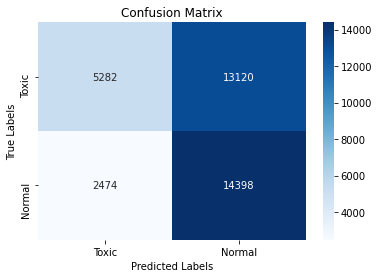

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import datetime

#시작 시간 설정
t0 = time.time()

y_pred = []
y_true = []

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_loader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_loader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(input_ids=batch[0],
                        token_type_ids= None,
                        attention_mask=batch[1])
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = batch[2].to('cpu').numpy()
    y_pred.extend(torch.argmax(outputs[0], 1).tolist())
    y_true.extend(batch[2].tolist())

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Toxic', 'Normal'])
ax.yaxis.set_ticklabels(['Toxic', 'Normal']);

###RoBERTa_ver1

#### last model

In [ ]:
#tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech", num_labels=2)
state_dict = torch.load('/content/drive/MyDrive/finalproject/roberta_ver1/E-2/VL-0.6815/pytorch_model.bin')
model.load_state_dict(state_dict)

device = xm.xla_device()
model = model.to(device)

  Batch   100  of  2,205.    Elapsed: 0:00:09.
  Batch   200  of  2,205.    Elapsed: 0:00:18.
  Batch   300  of  2,205.    Elapsed: 0:00:27.
  Batch   400  of  2,205.    Elapsed: 0:00:36.
  Batch   500  of  2,205.    Elapsed: 0:00:45.
  Batch   600  of  2,205.    Elapsed: 0:00:54.
  Batch   700  of  2,205.    Elapsed: 0:01:03.
  Batch   800  of  2,205.    Elapsed: 0:01:12.
  Batch   900  of  2,205.    Elapsed: 0:01:21.
  Batch 1,000  of  2,205.    Elapsed: 0:01:30.
  Batch 1,100  of  2,205.    Elapsed: 0:01:39.
  Batch 1,200  of  2,205.    Elapsed: 0:01:48.
  Batch 1,300  of  2,205.    Elapsed: 0:01:57.
  Batch 1,400  of  2,205.    Elapsed: 0:02:06.
  Batch 1,500  of  2,205.    Elapsed: 0:02:15.
  Batch 1,600  of  2,205.    Elapsed: 0:02:24.
  Batch 1,700  of  2,205.    Elapsed: 0:02:33.
  Batch 1,800  of  2,205.    Elapsed: 0:02:42.
  Batch 1,900  of  2,205.    Elapsed: 0:02:51.
  Batch 2,000  of  2,205.    Elapsed: 0:03:00.
  Batch 2,100  of  2,205.    Elapsed: 0:03:09.
  Batch 2,200

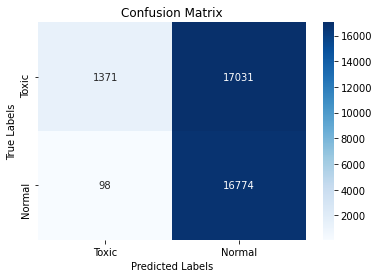

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import datetime

#시작 시간 설정
t0 = time.time()

y_pred = []
y_true = []

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_loader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_loader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(input_ids=batch[0],
                        token_type_ids= None,
                        attention_mask=batch[1])
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = batch[2].to('cpu').numpy()
    y_pred.extend(torch.argmax(outputs[0], 1).tolist())
    y_true.extend(batch[2].tolist())

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Toxic', 'Normal'])
ax.yaxis.set_ticklabels(['Toxic', 'Normal']);

####lowest val loss model

In [ ]:
#tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech", num_labels=2)
state_dict = torch.load('/content/drive/MyDrive/finalproject/roberta_ver1/E-1/VL-0.3709/pytorch_model.bin')
model.load_state_dict(state_dict)

device = xm.xla_device()
model = model.to(device)

  Batch   100  of  2,205.    Elapsed: 0:00:09.
  Batch   200  of  2,205.    Elapsed: 0:00:18.
  Batch   300  of  2,205.    Elapsed: 0:00:27.
  Batch   400  of  2,205.    Elapsed: 0:00:37.
  Batch   500  of  2,205.    Elapsed: 0:00:46.
  Batch   600  of  2,205.    Elapsed: 0:00:55.
  Batch   700  of  2,205.    Elapsed: 0:01:04.
  Batch   800  of  2,205.    Elapsed: 0:01:14.
  Batch   900  of  2,205.    Elapsed: 0:01:23.
  Batch 1,000  of  2,205.    Elapsed: 0:01:32.
  Batch 1,100  of  2,205.    Elapsed: 0:01:41.
  Batch 1,200  of  2,205.    Elapsed: 0:01:50.
  Batch 1,300  of  2,205.    Elapsed: 0:01:59.
  Batch 1,400  of  2,205.    Elapsed: 0:02:08.
  Batch 1,500  of  2,205.    Elapsed: 0:02:18.
  Batch 1,600  of  2,205.    Elapsed: 0:02:27.
  Batch 1,700  of  2,205.    Elapsed: 0:02:36.
  Batch 1,800  of  2,205.    Elapsed: 0:02:45.
  Batch 1,900  of  2,205.    Elapsed: 0:02:54.
  Batch 2,000  of  2,205.    Elapsed: 0:03:03.
  Batch 2,100  of  2,205.    Elapsed: 0:03:12.
  Batch 2,200

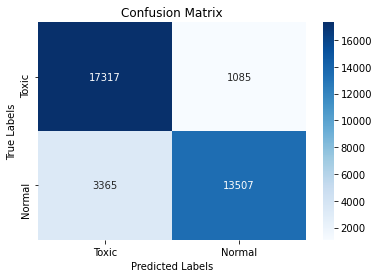

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import datetime

#시작 시간 설정
t0 = time.time()

y_pred = []
y_true = []

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_loader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_loader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(input_ids=batch[0],
                        token_type_ids= None,
                        attention_mask=batch[1])
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = batch[2].to('cpu').numpy()
    y_pred.extend(torch.argmax(outputs[0], 1).tolist())
    y_true.extend(batch[2].tolist())

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Toxic', 'Normal'])
ax.yaxis.set_ticklabels(['Toxic', 'Normal']);

###Squeeze_ver1

In [ ]:
tokenizer = SqueezeBertTokenizer.from_pretrained('squeezebert/squeezebert-uncased')

In [ ]:
def encode(text):
    return tokenizer(text, padding='max_length')

def torch_dataset(X,y):
    id = torch.tensor([data['input_ids'] for data in X], dtype=torch.long)
    token_ids = torch.tensor([data['token_type_ids'] for data in X], dtype=torch.long)
    mask = torch.tensor([data['attention_mask'] for data in X], dtype=torch.long)
    label = torch.tensor(y.values, dtype=torch.long)
    return TensorDataset(id, token_ids, mask, label)

test = torch_dataset(X_test.map(encode), y_test)
test_loader = DataLoader(test, shuffle=False, batch_size=16)

####lowest val loss model

In [ ]:
model = SqueezeBertForSequenceClassification.from_pretrained('squeezebert/squeezebert-uncased', num_labels=2)
state_dict = torch.load('/content/drive/MyDrive/finalproject/squeeze_ver1/E-1-VL-0.4368/pytorch_model.bin')
model.load_state_dict(state_dict)

device = xm.xla_device()
model = model.to(device)

  Batch   100  of  2,205.    Elapsed: 0:00:27.
  Batch   200  of  2,205.    Elapsed: 0:00:49.
  Batch   300  of  2,205.    Elapsed: 0:01:11.
  Batch   400  of  2,205.    Elapsed: 0:01:33.
  Batch   500  of  2,205.    Elapsed: 0:01:55.
  Batch   600  of  2,205.    Elapsed: 0:02:17.
  Batch   700  of  2,205.    Elapsed: 0:02:39.
  Batch   800  of  2,205.    Elapsed: 0:03:01.
  Batch   900  of  2,205.    Elapsed: 0:03:23.
  Batch 1,000  of  2,205.    Elapsed: 0:03:45.
  Batch 1,100  of  2,205.    Elapsed: 0:04:07.
  Batch 1,200  of  2,205.    Elapsed: 0:04:29.
  Batch 1,300  of  2,205.    Elapsed: 0:04:51.
  Batch 1,400  of  2,205.    Elapsed: 0:05:13.
  Batch 1,500  of  2,205.    Elapsed: 0:05:35.
  Batch 1,600  of  2,205.    Elapsed: 0:05:57.
  Batch 1,700  of  2,205.    Elapsed: 0:06:19.
  Batch 1,800  of  2,205.    Elapsed: 0:06:41.
  Batch 1,900  of  2,205.    Elapsed: 0:07:03.
  Batch 2,000  of  2,205.    Elapsed: 0:07:25.
  Batch 2,100  of  2,205.    Elapsed: 0:07:46.
  Batch 2,200

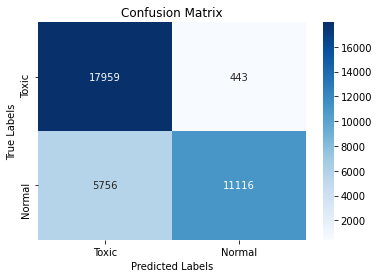

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

#시작 시간 설정
t0 = time.time()

y_pred = []
y_true = []

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_loader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_loader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(input_ids=batch[0],
                        token_type_ids= batch[1],
                        attention_mask=batch[2])
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = batch[3].to('cpu').numpy()
    y_pred.extend(torch.argmax(outputs[0], 1).tolist())
    y_true.extend(batch[3].tolist())

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Toxic', 'Normal'])
ax.yaxis.set_ticklabels(['Toxic', 'Normal']);

#### last model

In [ ]:
model = SqueezeBertForSequenceClassification.from_pretrained('squeezebert/squeezebert-uncased', num_labels=2)
state_dict = torch.load('/content/drive/MyDrive/finalproject/squeeze_ver1/E-4-VL-0.6932/pytorch_model.bin')
model.load_state_dict(state_dict)

device = xm.xla_device()
model = model.to(device)

Some weights of the model checkpoint at squeezebert/squeezebert-uncased were not used when initializing SqueezeBertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing SqueezeBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SqueezeBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SqueezeBertForSequenceClassification were no

  Batch   100  of  2,205.    Elapsed: 0:00:22.
  Batch   200  of  2,205.    Elapsed: 0:00:44.
  Batch   300  of  2,205.    Elapsed: 0:01:06.
  Batch   400  of  2,205.    Elapsed: 0:01:28.
  Batch   500  of  2,205.    Elapsed: 0:01:50.
  Batch   600  of  2,205.    Elapsed: 0:02:12.
  Batch   700  of  2,205.    Elapsed: 0:02:34.
  Batch   800  of  2,205.    Elapsed: 0:02:56.
  Batch   900  of  2,205.    Elapsed: 0:03:18.
  Batch 1,000  of  2,205.    Elapsed: 0:03:40.
  Batch 1,100  of  2,205.    Elapsed: 0:04:02.
  Batch 1,200  of  2,205.    Elapsed: 0:04:24.
  Batch 1,300  of  2,205.    Elapsed: 0:04:46.
  Batch 1,400  of  2,205.    Elapsed: 0:05:08.
  Batch 1,500  of  2,205.    Elapsed: 0:05:30.
  Batch 1,600  of  2,205.    Elapsed: 0:05:53.
  Batch 1,700  of  2,205.    Elapsed: 0:06:15.
  Batch 1,800  of  2,205.    Elapsed: 0:06:37.
  Batch 1,900  of  2,205.    Elapsed: 0:06:59.
  Batch 2,000  of  2,205.    Elapsed: 0:07:21.
  Batch 2,100  of  2,205.    Elapsed: 0:07:43.
  Batch 2,200

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


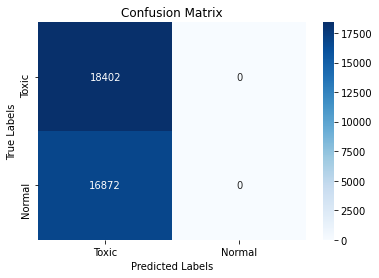

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

#시작 시간 설정
t0 = time.time()

y_pred = []
y_true = []

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_loader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_loader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(input_ids=batch[0],
                        token_type_ids= batch[1],
                        attention_mask=batch[2])
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = batch[3].to('cpu').numpy()
    y_pred.extend(torch.argmax(outputs[0], 1).tolist())
    y_true.extend(batch[3].tolist())

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Toxic', 'Normal'])
ax.yaxis.set_ticklabels(['Toxic', 'Normal']);

##Test on self dataset_ver2

### RoBERTa pre-trained model_ver2

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech", num_labels=2)

device = xm.xla_device()
model = model.to(device)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import datetime

#시작 시간 설정
t0 = time.time()

y_pred = []
y_true = []

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_loader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_loader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(input_ids=batch[0],
                        token_type_ids= None,
                        attention_mask=batch[1])
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = batch[2].to('cpu').numpy()
    y_pred.extend(torch.argmax(outputs[0], 1).tolist())
    y_true.extend(batch[2].tolist())

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Toxic', 'Normal'])
ax.yaxis.set_ticklabels(['Toxic', 'Normal']);

  Batch   100  of  2,233.    Elapsed: 0:00:08.
  Batch   200  of  2,233.    Elapsed: 0:00:17.
  Batch   300  of  2,233.    Elapsed: 0:00:25.
  Batch   400  of  2,233.    Elapsed: 0:00:33.
  Batch   500  of  2,233.    Elapsed: 0:00:42.
  Batch   600  of  2,233.    Elapsed: 0:00:50.
  Batch   700  of  2,233.    Elapsed: 0:00:58.
  Batch   800  of  2,233.    Elapsed: 0:01:07.
  Batch   900  of  2,233.    Elapsed: 0:01:15.
  Batch 1,000  of  2,233.    Elapsed: 0:01:24.
  Batch 1,100  of  2,233.    Elapsed: 0:01:32.
  Batch 1,200  of  2,233.    Elapsed: 0:01:40.
  Batch 1,300  of  2,233.    Elapsed: 0:01:49.
  Batch 1,400  of  2,233.    Elapsed: 0:01:57.
  Batch 1,500  of  2,233.    Elapsed: 0:02:05.
  Batch 1,600  of  2,233.    Elapsed: 0:02:14.
  Batch 1,700  of  2,233.    Elapsed: 0:02:22.
  Batch 1,800  of  2,233.    Elapsed: 0:02:31.
  Batch 1,900  of  2,233.    Elapsed: 0:02:39.
  Batch 2,000  of  2,233.    Elapsed: 0:02:47.
  Batch 2,100  of  2,233.    Elapsed: 0:02:56.
  Batch 2,200

###RoBERTa_ver2

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech", num_labels=2)
state_dict = torch.load('/content/drive/MyDrive/finalproject/roberta_ver2/E-1_VL-0.3701/pytorch_model.bin')
model.load_state_dict(state_dict)

device = xm.xla_device()
model = model.to(device)

In [ ]:
def encode(text):
    return tokenizer(text, padding='max_length', max_length=512, return_token_type_ids=False)

def torch_dataset(X,y):
    id = torch.tensor([data['input_ids'] for data in X], dtype=torch.long)
    mask = torch.tensor([data['attention_mask'] for data in X], dtype=torch.long)
    label = torch.tensor(y.values, dtype=torch.long)
    return TensorDataset(id, mask, label)

test = torch_dataset(X_test.map(encode), y_test)
test_loader = DataLoader(test, shuffle=False, batch_size=16)

  Batch   100  of  2,233.    Elapsed: 0:00:09.
  Batch   200  of  2,233.    Elapsed: 0:00:18.
  Batch   300  of  2,233.    Elapsed: 0:00:27.
  Batch   400  of  2,233.    Elapsed: 0:00:36.
  Batch   500  of  2,233.    Elapsed: 0:00:45.
  Batch   600  of  2,233.    Elapsed: 0:00:54.
  Batch   700  of  2,233.    Elapsed: 0:01:03.
  Batch   800  of  2,233.    Elapsed: 0:01:12.
  Batch   900  of  2,233.    Elapsed: 0:01:21.
  Batch 1,000  of  2,233.    Elapsed: 0:01:30.
  Batch 1,100  of  2,233.    Elapsed: 0:01:39.
  Batch 1,200  of  2,233.    Elapsed: 0:01:48.
  Batch 1,300  of  2,233.    Elapsed: 0:01:57.
  Batch 1,400  of  2,233.    Elapsed: 0:02:06.
  Batch 1,500  of  2,233.    Elapsed: 0:02:15.
  Batch 1,600  of  2,233.    Elapsed: 0:02:24.
  Batch 1,700  of  2,233.    Elapsed: 0:02:33.
  Batch 1,800  of  2,233.    Elapsed: 0:02:42.
  Batch 1,900  of  2,233.    Elapsed: 0:02:51.
  Batch 2,000  of  2,233.    Elapsed: 0:03:01.
  Batch 2,100  of  2,233.    Elapsed: 0:03:10.
  Batch 2,200

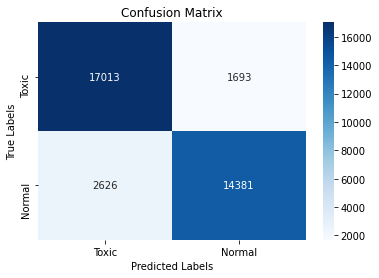

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import datetime

#시작 시간 설정
t0 = time.time()

y_pred = []
y_true = []

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_loader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_loader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(input_ids=batch[0],
                        token_type_ids= None,
                        attention_mask=batch[1])
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = batch[2].to('cpu').numpy()
    y_pred.extend(torch.argmax(outputs[0], 1).tolist())
    y_true.extend(batch[2].tolist())

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Toxic', 'Normal'])
ax.yaxis.set_ticklabels(['Toxic', 'Normal']);

###Squeeze_ver2

In [ ]:
tokenizer = SqueezeBertTokenizer.from_pretrained('squeezebert/squeezebert-uncased')

In [ ]:
def encode(text):
    return tokenizer(text, padding='max_length')

def torch_dataset(X,y):
    id = torch.tensor([data['input_ids'] for data in X], dtype=torch.long)
    #token_ids = torch.tensor([data['token_type_ids'] for data in X], dtype=torch.long)
    mask = torch.tensor([data['attention_mask'] for data in X], dtype=torch.long)
    label = torch.tensor(y.values, dtype=torch.long)
    return TensorDataset(id, mask, label)

test = torch_dataset(X_test.map(encode), y_test)
test_loader = DataLoader(test, shuffle=False, batch_size=16)

#### lowest val loss model

In [ ]:
model = SqueezeBertForSequenceClassification.from_pretrained('squeezebert/squeezebert-uncased', num_labels=2)
state_dict = torch.load('/content/drive/MyDrive/finalproject/squeeze_ver2/E-3-VL-0.6932/pytorch_model.bin')
model.load_state_dict(state_dict)

device = xm.xla_device()
model = model.to(device)

  Batch   100  of  2,233.    Elapsed: 0:00:22.
  Batch   200  of  2,233.    Elapsed: 0:00:43.
  Batch   300  of  2,233.    Elapsed: 0:01:05.
  Batch   400  of  2,233.    Elapsed: 0:01:27.
  Batch   500  of  2,233.    Elapsed: 0:01:49.
  Batch   600  of  2,233.    Elapsed: 0:02:10.
  Batch   700  of  2,233.    Elapsed: 0:02:32.
  Batch   800  of  2,233.    Elapsed: 0:02:54.
  Batch   900  of  2,233.    Elapsed: 0:03:16.
  Batch 1,000  of  2,233.    Elapsed: 0:03:37.
  Batch 1,100  of  2,233.    Elapsed: 0:03:59.
  Batch 1,200  of  2,233.    Elapsed: 0:04:21.
  Batch 1,300  of  2,233.    Elapsed: 0:04:43.
  Batch 1,400  of  2,233.    Elapsed: 0:05:04.
  Batch 1,500  of  2,233.    Elapsed: 0:05:26.
  Batch 1,600  of  2,233.    Elapsed: 0:05:48.
  Batch 1,700  of  2,233.    Elapsed: 0:06:10.
  Batch 1,800  of  2,233.    Elapsed: 0:06:31.
  Batch 1,900  of  2,233.    Elapsed: 0:06:53.
  Batch 2,000  of  2,233.    Elapsed: 0:07:15.
  Batch 2,100  of  2,233.    Elapsed: 0:07:37.
  Batch 2,200

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


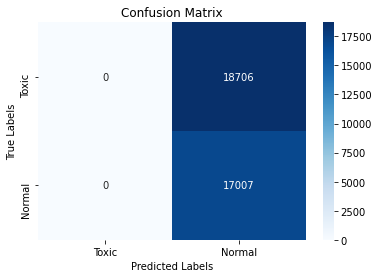

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

#시작 시간 설정
t0 = time.time()

y_pred = []
y_true = []

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_loader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_loader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(input_ids=batch[0],
                        token_type_ids= None,
                        attention_mask=batch[1])
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = batch[2].to('cpu').numpy()
    y_pred.extend(torch.argmax(outputs[0], 1).tolist())
    y_true.extend(batch[2].tolist())

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Toxic', 'Normal'])
ax.yaxis.set_ticklabels(['Toxic', 'Normal']);

#### last model

In [ ]:
model = SqueezeBertForSequenceClassification.from_pretrained('squeezebert/squeezebert-uncased', num_labels=2)
state_dict = torch.load('/content/drive/MyDrive/finalproject/squeeze_ver2/E-4-VL-0.6944/pytorch_model.bin')
model.load_state_dict(state_dict)

device = xm.xla_device()
model = model.to(device)

  Batch   100  of  2,233.    Elapsed: 0:00:22.
  Batch   200  of  2,233.    Elapsed: 0:00:44.
  Batch   300  of  2,233.    Elapsed: 0:01:06.
  Batch   400  of  2,233.    Elapsed: 0:01:27.
  Batch   500  of  2,233.    Elapsed: 0:01:49.
  Batch   600  of  2,233.    Elapsed: 0:02:11.
  Batch   700  of  2,233.    Elapsed: 0:02:33.
  Batch   800  of  2,233.    Elapsed: 0:02:54.
  Batch   900  of  2,233.    Elapsed: 0:03:16.
  Batch 1,000  of  2,233.    Elapsed: 0:03:38.
  Batch 1,100  of  2,233.    Elapsed: 0:04:00.
  Batch 1,200  of  2,233.    Elapsed: 0:04:21.
  Batch 1,300  of  2,233.    Elapsed: 0:04:43.
  Batch 1,400  of  2,233.    Elapsed: 0:05:05.
  Batch 1,500  of  2,233.    Elapsed: 0:05:27.
  Batch 1,600  of  2,233.    Elapsed: 0:05:48.
  Batch 1,700  of  2,233.    Elapsed: 0:06:10.
  Batch 1,800  of  2,233.    Elapsed: 0:06:32.
  Batch 1,900  of  2,233.    Elapsed: 0:06:53.
  Batch 2,000  of  2,233.    Elapsed: 0:07:15.
  Batch 2,100  of  2,233.    Elapsed: 0:07:37.
  Batch 2,200

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


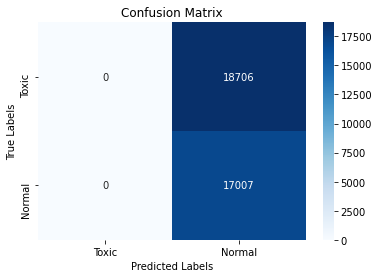

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

#시작 시간 설정
t0 = time.time()

y_pred = []
y_true = []

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_loader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_loader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(input_ids=batch[0],
                        token_type_ids= None,
                        attention_mask=batch[1])
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = batch[2].to('cpu').numpy()
    y_pred.extend(torch.argmax(outputs[0], 1).tolist())
    y_true.extend(batch[2].tolist())

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Toxic', 'Normal'])
ax.yaxis.set_ticklabels(['Toxic', 'Normal']);

##Test on another dataset

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/finalproject/finaldata/test.csv')
test

,target,cleaned_comment
0,1,german lawmakers approve no means no rape law ...
1,1,german lawmakers approve no means no rape law ...
2,0,german lawmakers approve no means no rape law ...
3,1,german lawmakers approve no means no rape law ...
4,1,german lawmakers approve no means no rape law ...
...,...,...
1442,0,fury as feminist blames toddler alligator deat...
1443,1,fury as feminist blames toddler alligator deat...
1444,1,fury as feminist blames toddler alligator deat...
1445,1,fury as feminist blames toddler alligator deat...


In [ ]:
X_test = test['cleaned_comment']
y_test = test['target']

test = torch_dataset(X_test.map(encode), y_test)
test_loader = DataLoader(test, shuffle=False, batch_size=16)

###RoBERTa pretrained model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech", num_labels=2)
# state_dict = torch.load('/content/drive/MyDrive/finalproject/roberta_ver2/E-1_VL-0.3701/pytorch_model.bin')
# model.load_state_dict(state_dict)

device = xm.xla_device()
model = model.to(device)

In [ ]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_loader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_loader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))


Accuracy: 0.49
Test took: 0:00:10


###RoBERTa_ver1

####lowest val loss model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech", num_labels=2)
state_dict = torch.load('/content/drive/MyDrive/finalproject/roberta_ver1/E-1/VL-0.3709/pytorch_model.bin')
model.load_state_dict(state_dict)

device = xm.xla_device()
model = model.to(device)

In [ ]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_loader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_loader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))


Accuracy: 0.28
Test took: 0:00:08


#### last model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech", num_labels=2)
state_dict = torch.load('/content/drive/MyDrive/finalproject/roberta_ver1/E-2/VL-0.6815/pytorch_model.bin')
model.load_state_dict(state_dict)

device = xm.xla_device()
model = model.to(device)

In [ ]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_loader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_loader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))


Accuracy: 0.72
Test took: 0:00:08


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import datetime

#시작 시간 설정
t0 = time.time()

y_pred = []
y_true = []

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_loader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_loader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(input_ids=batch[0],
                        token_type_ids= None,
                        attention_mask=batch[1])
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = batch[2].to('cpu').numpy()
    y_pred.extend(torch.argmax(outputs[0], 1).tolist())
    y_true.extend(batch[2].tolist())

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Toxic', 'Normal'])
ax.yaxis.set_ticklabels(['Toxic', 'Normal']);

###Squeeze_ver1

####lowest val loss

In [ ]:
model = SqueezeBertForSequenceClassification.from_pretrained('squeezebert/squeezebert-uncased', num_labels=2)
state_dict = torch.load('/content/drive/MyDrive/finalproject/squeeze_ver1/E-1-VL-0.4368/pytorch_model.bin')
model.load_state_dict(state_dict)

device = xm.xla_device()
model = model.to(device)

Some weights of the model checkpoint at squeezebert/squeezebert-uncased were not used when initializing SqueezeBertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing SqueezeBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SqueezeBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SqueezeBertForSequenceClassification were no

In [ ]:
def encode(text):
    return tokenizer(text, padding='max_length')

def torch_dataset(X,y):
    id = torch.tensor([data['input_ids'] for data in X], dtype=torch.long)
    token_ids = torch.tensor([data['token_type_ids'] for data in X], dtype=torch.long)
    mask = torch.tensor([data['attention_mask'] for data in X], dtype=torch.long)
    label = torch.tensor(y.values, dtype=torch.long)
    return TensorDataset(id, token_ids, mask, label)

test = torch_dataset(X_test.map(encode), y_test)
test_loader = DataLoader(test, shuffle=True, batch_size=16)


Accuracy: 0.32
Test took: 0:00:20
Classification Report:
              precision    recall  f1-score   support

           1     0.2830    0.9401    0.4351       401
           0     0.7913    0.0870    0.1568      1046

    accuracy                         0.3234      1447
   macro avg     0.5372    0.5136    0.2959      1447
weighted avg     0.6504    0.3234    0.2339      1447



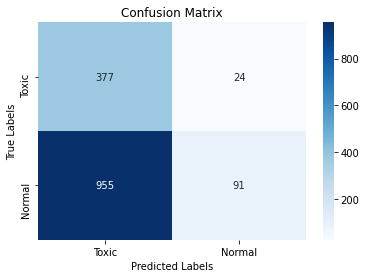

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

#시작 시간 설정
t0 = time.time()

y_pred = []
y_true = []

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_loader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_loader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(input_ids=batch[0],
                        token_type_ids= batch[1],
                        attention_mask=batch[2])
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = batch[3].to('cpu').numpy()
    y_pred.extend(torch.argmax(outputs[0], 1).tolist())
    y_true.extend(batch[3].tolist())

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Toxic', 'Normal'])
ax.yaxis.set_ticklabels(['Toxic', 'Normal']);

####latest model

In [ ]:
model = SqueezeBertForSequenceClassification.from_pretrained('squeezebert/squeezebert-uncased', num_labels=2)
state_dict = torch.load('/content/drive/MyDrive/finalproject/squeeze_ver1/E-1-VL-0.4368/pytorch_model.bin')
model.load_state_dict(state_dict)

device = xm.xla_device()
model = model.to(device)

In [ ]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_loader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_loader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
        
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(input_ids=batch[0],
                        token_type_ids= batch[1],
                        attention_mask=batch[2])
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = labels=batch[3].unsqueeze(0).to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))


Accuracy: 0.28
Test took: 0:00:19



Accuracy: 0.28
Test took: 0:00:20
Classification Report:
              precision    recall  f1-score   support

           1     0.2771    1.0000    0.4340       401
           0     0.0000    0.0000    0.0000      1046

    accuracy                         0.2771      1447
   macro avg     0.1386    0.5000    0.2170      1447
weighted avg     0.0768    0.2771    0.1203      1447



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


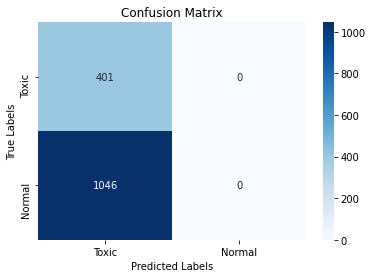

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

#시작 시간 설정
t0 = time.time()

y_pred = []
y_true = []

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_loader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_loader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(input_ids=batch[0],
                        token_type_ids= batch[1],
                        attention_mask=batch[2])
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = batch[3].to('cpu').numpy()
    y_pred.extend(torch.argmax(outputs[0], 1).tolist())
    y_true.extend(batch[3].tolist())

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Toxic', 'Normal'])
ax.yaxis.set_ticklabels(['Toxic', 'Normal']);

In [ ]:
test.target.value_counts()

0    1046
1     401
Name: target, dtype: int64

###RoBERTa_ver2

####last model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech", num_labels=2)
state_dict = torch.load('/content/drive/MyDrive/finalproject/roberta_ver2/E-1_VL-0.3701/pytorch_model.bin')
model.load_state_dict(state_dict)

device = xm.xla_device()
model = model.to(device)

In [ ]:
X_test = test['cleaned_comment']
y_test = test['target']

enc_test = X_test.map(encode)
test = torch_dataset(enc_test, y_test)

In [ ]:
from sklearn.metrics import confusion_matrix

#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for batch in enumerate(test_loader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_loader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.squeeze(0).to('cpu').numpy()

    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))


Accuracy: 0.28
Test took: 0:00:08


###Squeeze_ver2

lowest val loss

In [ ]:
tokenizer = SqueezeBertTokenizer.from_pretrained('squeezebert/squeezebert-uncased')
model = SqueezeBertForSequenceClassification.from_pretrained('squeezebert/squeezebert-uncased', num_labels=2)
state_dict = torch.load('/content/drive/MyDrive/finalproject/squeeze_ver2/E-2-VL-0.6932/pytorch_model.bin')
model.load_state_dict(state_dict)

device = xm.xla_device()
model = model.to(device)

In [ ]:
def encode(text):
    return tokenizer(text, padding='max_length', max_length=512, return_token_type_ids=False)

def torch_dataset(X,y):
    id = torch.tensor([data['input_ids'] for data in X], dtype=torch.long)
    #token_ids = torch.tensor([data['token_type_ids'] for data in X], dtype=torch.long)
    mask = torch.tensor([data['attention_mask'] for data in X], dtype=torch.long)
    label = torch.tensor(y.values, dtype=torch.long)
    return TensorDataset(id, mask, label)

test = torch_dataset(X_test.map(encode), y_test)
test_loader = DataLoader(test, shuffle=True, batch_size=16)

In [ ]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_loader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_loader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
       
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(input_ids=batch[0],
                        token_type_ids= None,
                        attention_mask=batch[1])
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = batch[2].unsqueeze(0).to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))


Accuracy: 0.28
Test took: 0:00:24



Accuracy: 0.28
Test took: 0:00:20
Classification Report:
              precision    recall  f1-score   support

           1     0.2771    1.0000    0.4340       401
           0     0.0000    0.0000    0.0000      1046

    accuracy                         0.2771      1447
   macro avg     0.1386    0.5000    0.2170      1447
weighted avg     0.0768    0.2771    0.1203      1447



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


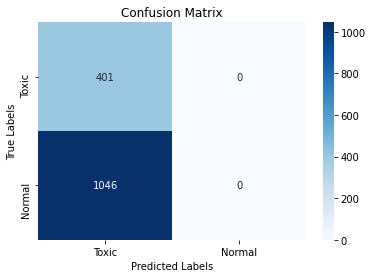

In [ ]:
#시작 시간 설정
t0 = time.time()

y_pred = []
y_true = []

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_loader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_loader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(input_ids=batch[0],
                        token_type_ids= None,
                        attention_mask=batch[1])
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = batch[2].to('cpu').numpy()
    y_pred.extend(torch.argmax(outputs[0], 1).tolist())
    y_true.extend(batch[2].tolist())

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Toxic', 'Normal'])
ax.yaxis.set_ticklabels(['Toxic', 'Normal']);

latest model

In [ ]:
model = SqueezeBertForSequenceClassification.from_pretrained('squeezebert/squeezebert-uncased', num_labels=2)
state_dict = torch.load('/content/drive/MyDrive/finalproject/squeeze_ver2/E-4-VL-0.6944/pytorch_model.bin')
model.load_state_dict(state_dict)

device = xm.xla_device()
model = model.to(device)


Accuracy: 0.72
Test took: 0:00:20
Classification Report:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000       401
           0     0.7229    1.0000    0.8391      1046

    accuracy                         0.7229      1447
   macro avg     0.3614    0.5000    0.4196      1447
weighted avg     0.5225    0.7229    0.6066      1447



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


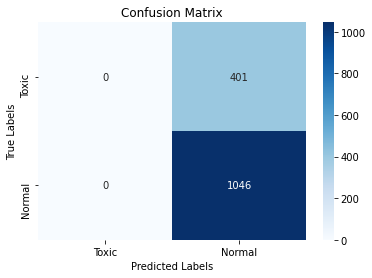

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

#시작 시간 설정
t0 = time.time()

y_pred = []
y_true = []

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_loader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_loader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(input_ids=batch[0],
                        token_type_ids= None,
                        attention_mask=batch[1])
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = batch[2].to('cpu').numpy()
    y_pred.extend(torch.argmax(outputs[0], 1).tolist())
    y_true.extend(batch[2].tolist())

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Toxic', 'Normal'])
ax.yaxis.set_ticklabels(['Toxic', 'Normal']);

##Test on new sentence

In [ ]:
# 입력 데이터 변환
def convert_input_data(sentence, tokenizer, model_type='roberta'):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    #tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
    MAX_LEN = 512 # 입력 토큰의 최대 시퀀스 길이
    if model_type == 'squeeze':
        tokenized_texts = tokenizer(sentence, max_length=512, pad_to_max_length=True, return_attention_mask=False)
        input_ids = [tokenized_texts['input_ids']]
        
    elif model_type == 'squeeze_2':
        tokenized_texts = tokenizer(sentence, padding='max_length', return_token_type_ids=False, return_attention_mask=False)
        input_ids = [tokenized_texts['input_ids']]

    else:
        tokenized_texts = tokenizer(sentence, padding='max_length', return_token_type_ids=False, return_attention_mask=False)
        input_ids = tokenized_texts['input_ids']
    
    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)
    if model_type == 'squeeze':
        token_id = torch.tensor([tokenized_texts['token_type_ids']])

        return inputs, token_id, masks

    return inputs, masks

In [ ]:
# 문장 테스트
def test_sentences(sentence, model, tokenizer, model_type='roberta'):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    if model_type == 'squeeze':
        inputs, token_id, masks  = convert_input_data(sentence, tokenizer, model_type)
    else:
        inputs, masks = convert_input_data(sentence, tokenizer, model_type)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
    if model_type == 'squeeze':
        b_token_id = token_id.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=b_token_id if model == 'squeeze' else None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [ ]:
from keras.preprocessing.sequence import pad_sequences

roberta_ver1_low = torch.load('/content/drive/MyDrive/finalproject/roberta_ver1/E-1/VL-0.3709/pytorch_model.bin')
roberta_ver1_last = torch.load('/content/drive/MyDrive/finalproject/roberta_ver1/E-2/VL-0.6815/pytorch_model.bin')

squeeze_ver1_low = torch.load('/content/drive/MyDrive/finalproject/squeeze_ver1/E-1-VL-0.4368/pytorch_model.bin')
squeeze_ver1_last = torch.load('/content/drive/MyDrive/finalproject/squeeze_ver1/E-4-VL-0.6932/pytorch_model.bin')

roberta_ver2 = torch.load('/content/drive/MyDrive/finalproject/roberta_ver2/E-1_VL-0.3701/pytorch_model.bin')

squeeze_ver2_low = torch.load('/content/drive/MyDrive/finalproject/squeeze_ver2/E-3-VL-0.6932/pytorch_model.bin')
squeeze_ver2_last = torch.load('/content/drive/MyDrive/finalproject/squeeze_ver2/E-4-VL-0.6944/pytorch_model.bin')

states = [None, roberta_ver1_low, roberta_ver1_last, roberta_ver2, squeeze_ver1_low, squeeze_ver1_last, squeeze_ver2_low, squeeze_ver2_last]
models = {'roberta': AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech", num_labels=2),
          'squeeze': SqueezeBertForSequenceClassification.from_pretrained('squeezebert/squeezebert-uncased', num_labels=2)}
toks = {'roberta':AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech"),
              'squeeze': SqueezeBertTokenizer.from_pretrained('squeezebert/squeezebert-uncased')}

In [ ]:
import time

def run_test(sentence, model, state_dict, tokenizer, model_type='roberta'):
    if state_dict:
        model.load_state_dict(state_dict)
    model = model.to(device)
    start_time = time.time()
    logits = test_sentences(sentence, model, tokenizer, model_type)
    pred = np.argmax(logits)
    end_time = time.time()-start_time 
    return pred, end_time

In [ ]:
preds = {'how do you think of gay [SEP] they are disgusting':[1],
            'how do you think of gay':[0],
            'they are disgusting':[1],
            'its too hot outside [SEP] take off your jacket':[0],
            'hi im highschool student [SEP] take off your skirt':[1],
            'its too hot outside':[0],
            'take off your jacket':[0],
            'hi im highschool student':[0],
            'hi take off your skirt':[0]}

times = dict()

for i, state in enumerate(states):
    if i < 4:
        model = models['roberta']
        tokenizer = toks['roberta']
        for sent in preds.keys():
            pred, end_time = run_test([sent], model, state, tokenizer, model_type='roberta')
            preds[sent].append(pred)
            if i == 0:
                times[sent] = [end_time]
            else:
                times[sent].append(end_time)
    elif i < 6:
        model = models['squeeze']
        tokenizer = toks['squeeze']
        for sent in preds.keys():
            pred, end_time = run_test(sent, model, state, tokenizer, model_type='squeeze') 
            preds[sent].append(pred)
            times[sent].append(end_time) 
    else:
        model = models['squeeze']
        tokenizer = toks['squeeze']
        for sent in preds.keys():
            pred, end_time = run_test(sent, model, state, tokenizer, model_type='squeeze_2') 
            preds[sent].append(pred)
            times[sent].append(end_time)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
idx = ['target label','roberta_basic', 'roberta_ver1_low', 'roberta_ver1_last', 'roberta_ver2', 'squeeze_ver1_low', 'squeeze_ver1_last', 'squeeze_ver2_low', 'squeeze_ver2_last']
result = pd.DataFrame(preds, index=idx)
result

,how do you think of gay [SEP] they are disgusting,how do you think of gay,they are disgusting,its too hot outside [SEP] take off your jacket,hi im highschool student [SEP] take off your skirt,its too hot outside,take off your jacket,hi im highschool student,hi take off your skirt
target label,1,0,1,0,1,0,0,0,0
roberta_basic,1,0,1,1,0,0,0,0,0
roberta_ver1_low,1,1,1,1,1,1,1,1,1
roberta_ver1_last,0,0,0,0,0,0,0,0,0
roberta_ver2,1,0,1,1,0,0,0,0,0
squeeze_ver1_low,1,1,1,1,1,1,1,1,1
squeeze_ver1_last,1,1,1,1,1,1,1,1,1
squeeze_ver2_low,0,0,0,0,0,0,0,0,0
squeeze_ver2_last,0,0,0,0,0,0,0,0,0


In [ ]:
pd.DataFrame(times, index=idx[1:])

,how do you think of gay [SEP] they are disgusting,how do you think of gay,they are disgusting,its too hot outside [SEP] take off your jacket,hi im highschool student [SEP] take off your skirt,its too hot outside,take off your jacket,hi im highschool student,hi take off your skirt
roberta_basic,0.192027,0.189782,0.198951,0.197859,0.194123,0.193817,0.203512,0.207704,0.213288
roberta_ver1_low,0.213657,0.211056,0.192491,0.206127,0.208262,0.206100,0.208254,0.199059,0.196490
roberta_ver1_last,0.200856,0.209429,0.210787,0.208691,0.212934,0.215897,0.223727,0.220795,0.221057
roberta_ver2,0.219384,0.221817,0.218638,0.206136,0.211859,0.215880,0.219164,0.218253,0.221088
squeeze_ver1_low,0.212652,0.211112,0.212263,0.220017,0.222906,0.233503,0.222740,0.225637,0.227933
squeeze_ver1_last,0.231694,0.232717,0.230820,0.228280,0.225470,0.229012,0.232956,0.237682,0.235001
squeeze_ver2_low,0.237080,0.231465,0.262463,0.236080,0.253618,0.246761,0.259147,0.263719,0.264930
squeeze_ver2_last,0.259484,0.258293,0.247171,0.248067,0.255952,0.254580,0.249837,0.252451,0.255497
